Le but de ce fichier est de créer un réseau de neurones et de l'entrainer sur nos données.

In [1]:
import pandas as pd
import numpy as np
import io
import os
import csv
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns
from matplotlib.ticker import  MultipleLocator, FormatStrFormatter
import re
import math

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import models, transforms, datasets
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm

from sklearn.cluster import estimate_bandwidth, MeanShift

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Using gpu: %s ' % torch.cuda.is_available())

Using gpu: True 


# Data loading and conversion

In [2]:
df_try=pd.read_csv('train_avant_tenseur.csv')
df_try=df_try.drop(df_try.columns[0],axis=1)
df_try.dropna(axis=0, inplace=True)
df_try.head()

,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,WEEK_OF_YEAR,DAY_OF_WEEK,QUARTER_HOUR,START_1_LON,START_1_LAT,START_2_LON,START_2_LAT,...,END_2_LON,END_2_LAT,END_3_LON,END_3_LAT,END_4_LON,END_4_LAT,END_5_LON,END_5_LAT,LABEL_LON,LABEL_LAT
0,57105,63,380,26,0,0,-8.618643,41.141412,-8.618499,41.141376,...,-8.631738,41.148225,-8.629938,41.150385,-8.629110,41.151213,-8.629128,41.151240,-8.630838,41.154489
1,57105,6,384,26,0,0,-8.639847,41.159826,-8.640351,41.159871,...,-8.660178,41.163192,-8.663112,41.163687,-8.666235,41.164200,-8.669169,41.164704,-8.665740,41.170671
2,57105,63,217,26,0,0,-8.612964,41.140359,-8.613378,41.140350,...,-8.649900,41.154264,-8.599383,41.141736,-8.596530,41.140566,-8.650080,41.154291,-8.615970,41.140530
3,57105,63,343,26,0,0,-8.574678,41.151951,-8.574705,41.151942,...,-8.598690,41.146119,-8.598816,41.146101,-8.600193,41.146155,-8.601057,41.146101,-8.607996,41.142915
4,57105,63,230,26,0,0,-8.645994,41.180490,-8.645949,41.180517,...,-8.676918,41.171841,-8.680032,41.171949,-8.682615,41.173191,-8.685441,41.173776,-8.687268,41.178087


In [3]:
train_labels = np.column_stack([df_try['LABEL_LON'], df_try['LABEL_LAT'] ])
train_tensor_label = torch.tensor(df_try[['LABEL_LON','LABEL_LAT']].values.astype('float64'))
train_tensor_client = torch.tensor(df_try[['ORIGIN_CALL']].values.astype('int64'))
train_tensor_stand = torch.tensor(df_try[['ORIGIN_STAND']].values.astype('int64'))
train_tensor_taxi = torch.tensor(df_try[['TAXI_ID']].values.astype('int64'))
train_tensor_week = torch.tensor(df_try[['WEEK_OF_YEAR']].values.astype('int64'))
train_tensor_day = torch.tensor(df_try[['DAY_OF_WEEK']].values.astype('int64'))
train_tensor_quarter = torch.tensor(df_try[['QUARTER_HOUR']].values.astype('int64'))
df_try_2=df_try.drop(['LABEL_LON','LABEL_LAT','QUARTER_HOUR','DAY_OF_WEEK','WEEK_OF_YEAR','TAXI_ID','ORIGIN_STAND','ORIGIN_CALL'],axis=1)
train_tensor_points = torch.tensor(df_try_2.values.astype('float32'))

# Neural network class

In [5]:
class Network(nn.Module):
    def __init__(self, clusters):
        super(Network, self).__init__()
        
        self.clusters = clusters
        self.fc1= nn.Linear(80, 500)
        self.fc2= nn.Linear(500, len(clusters))

        self.emb_client = nn.Embedding(57106, 10)
        self.emb_stand = nn.Embedding(64, 10)
        self.emb_taxi = nn.Embedding(448, 10)
        self.emb_week = nn.Embedding(52, 10)
        self.emb_day = nn.Embedding(7, 10)
        self.emb_quarter = nn.Embedding(96, 10)
        
        self.relu = nn.ReLU(inplace=True)
        self.bn = nn.BatchNorm1d(500)
        self.soft = nn.Softmax()

    def forward(self, traj, client, stand, taxi, week, day, quarter):
        # Embedding of the metadata
        client = self.emb_client(client)
        stand = self.emb_stand(stand)
        taxi = self.emb_taxi(taxi)
        week = self.emb_week(week)
        day = self.emb_day(day)
        quarter = self.emb_quarter(quarter)
        
        # Concatenation of the embedding output and of the trajectories
        batch = torch.cat((traj, client.view(-1,10), stand.view(-1,10), taxi.view(-1,10),
                           week.view(-1,10), day.view(-1,10), quarter.view(-1,10)), dim=1)

        # Computation of the porbabilities of each centroid
        output = self.relu(self.fc1(batch))
        output = self.bn(output)
        output = self.fc2(output)
        output = self.soft(output)

        # Computation of the weighted average of the centroids 
        output = torch.mm(output, clusters)

        return output

# Loss function

In [4]:
class equi_rec_loss(nn.Module):

    def __init__(self):
        super(equi_rec_loss, self).__init__()
        self.R = 6371
        self.deg2rad = 3.14/180.

    def forward(self, pos1, pos2):  
        long1 = pos1[:,0] * self.deg2rad
        lat1 = pos1[:,1] * self.deg2rad
        long2 = pos2[:,0] * self.deg2rad
        lat2 = pos2[:,1] * self.deg2rad
            
        x = (long2-long1) * torch.cos((lat1+lat2)/2)
        y = (lat2-lat1)

        loss = torch.mean(torch.sqrt(x**2 + y**2), dim=0)  * self.R
        return loss

# Clustering function

In [6]:
def get_clusters(coords):
    """
    Estimate clusters for the given list of coordinates.
    """
    # First, grossly reduce the spatial dataset by rounding up the coordinates to the 4th decimal
    # (i.e. 11 meters. See: https://en.wikipedia.org/wiki/Decimal_degrees)
    clusters = pd.DataFrame({
        'approx_longitudes': coords[:,0].round(4),
        'approx_latitudes': coords[:,1].round(4)
    })
    clusters = clusters.drop_duplicates(['approx_longitudes', 'approx_latitudes'])
    clusters = clusters.as_matrix()
    
    ms = MeanShift(bandwidth=0.01, bin_seeding=True)
    ms.fit(clusters)
    return torch.Tensor(ms.cluster_centers_).to(device)

In [9]:
clusters = get_clusters(train_labels)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if sys.path[0] == '':


# Data loader

In [8]:
batch_size = 200

In [10]:
# Create dataloader
dataloader = DataLoader(TensorDataset(
    train_tensor_points,train_tensor_client,train_tensor_stand,train_tensor_taxi,
    train_tensor_week,train_tensor_day, train_tensor_quarter,train_tensor_label),
     batch_size=batch_size, shuffle=True)

# Network creation

In [11]:
network = Network(clusters)
network = network.to(device)
optimizer = torch.optim.SGD(network.parameters(), lr=0.01, momentum=0.9)
criterion = equi_rec_loss()

# Train function

In [12]:
def train(model,dataloader,batch_size,epochs,optimizer, name='Model_avec_clusters', save_model=2):
    model.train()
    l=[]
    n_epoch = -1
    for epoch in tqdm(range(epochs)):
        n_epoch += 1
        running_loss = 0.0
        count = 0
        for traj, client, stand, taxi, week, day, quarter, targets in dataloader:
            traj = traj.to(device)
            targets = targets.to(device)
            client = client.to(device)
            stand = stand.to(device)
            taxi = taxi.to(device)
            week = week.to(device)
            day = day.to(device)
            quarter = quarter.to(device)
            
            outputs = model(traj, client, stand, taxi, week, day, quarter)
            loss = criterion(outputs.double(),targets)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # statistics
            running_loss += loss.data.item()
            count += 1
        
        epoch_loss = running_loss / count
        l.append(epoch_loss)
        if epoch%1==0:
            print('Loss: {:.4f}'.format(
                      epoch_loss))
            
        if epoch%save_model==0:
            torch.save(model.state_dict(),f"model_cluster/{name}_{epoch}.pth")
            
    with open(f"loss_cluster/{name}_scores.txt", 'w') as file:
        file.writelines(["%s\n" % item  for item in l])
            
    plt.plot(l)
    return l
    

  1%|          | 1/135 [01:06<2:27:54, 66.23s/it]

Loss: 2.3409


  1%|▏         | 2/135 [02:11<2:26:24, 66.05s/it]

Loss: 2.0301


  2%|▏         | 3/135 [03:17<2:25:20, 66.07s/it]

Loss: 2.0162


  3%|▎         | 4/135 [04:23<2:24:05, 66.00s/it]

Loss: 1.9704


  4%|▎         | 5/135 [05:29<2:22:38, 65.83s/it]

Loss: 1.9397


  4%|▍         | 6/135 [06:34<2:21:18, 65.72s/it]

Loss: 1.9228


  5%|▌         | 7/135 [07:40<2:20:12, 65.73s/it]

Loss: 1.9119


  6%|▌         | 8/135 [08:46<2:19:13, 65.78s/it]

Loss: 1.9024


  7%|▋         | 9/135 [09:51<2:17:57, 65.70s/it]

Loss: 1.8923


  7%|▋         | 10/135 [10:57<2:16:35, 65.57s/it]

Loss: 1.8840


  8%|▊         | 11/135 [12:01<2:15:02, 65.34s/it]

Loss: 1.8754


  9%|▉         | 12/135 [13:07<2:13:47, 65.27s/it]

Loss: 1.8702


 10%|▉         | 13/135 [14:12<2:12:32, 65.18s/it]

Loss: 1.8618


 10%|█         | 14/135 [15:16<2:11:03, 64.98s/it]

Loss: 1.8559


 11%|█         | 15/135 [16:21<2:09:56, 64.97s/it]

Loss: 1.8484


 12%|█▏        | 16/135 [17:26<2:09:01, 65.06s/it]

Loss: 1.8440


 13%|█▎        | 17/135 [18:32<2:08:05, 65.13s/it]

Loss: 1.8378


 13%|█▎        | 18/135 [19:37<2:07:10, 65.22s/it]

Loss: 1.8330


 14%|█▍        | 19/135 [20:41<2:05:33, 64.94s/it]

Loss: 1.8261


 15%|█▍        | 20/135 [21:46<2:04:24, 64.91s/it]

Loss: 1.8218


 16%|█▌        | 21/135 [22:51<2:03:16, 64.88s/it]

Loss: 1.8171


 16%|█▋        | 22/135 [23:56<2:02:05, 64.82s/it]

Loss: 1.8130


 17%|█▋        | 23/135 [25:01<2:01:14, 64.95s/it]

Loss: 1.8073


 18%|█▊        | 24/135 [26:06<2:00:27, 65.11s/it]

Loss: 1.8023


 19%|█▊        | 25/135 [27:12<1:59:34, 65.22s/it]

Loss: 1.7982


 19%|█▉        | 26/135 [28:17<1:58:22, 65.16s/it]

Loss: 1.7936


 20%|██        | 27/135 [29:22<1:57:15, 65.14s/it]

Loss: 1.7902


 21%|██        | 28/135 [30:26<1:55:45, 64.91s/it]

Loss: 1.7852


 21%|██▏       | 29/135 [31:31<1:54:35, 64.87s/it]

Loss: 1.8163


 22%|██▏       | 30/135 [32:36<1:53:36, 64.92s/it]

Loss: 1.8417


 23%|██▎       | 31/135 [33:41<1:52:40, 65.00s/it]

Loss: 1.7928


 24%|██▎       | 32/135 [34:47<1:51:55, 65.20s/it]

Loss: 1.7850


 24%|██▍       | 33/135 [35:52<1:50:43, 65.13s/it]

Loss: 1.7794


 25%|██▌       | 34/135 [36:57<1:49:44, 65.19s/it]

Loss: 1.7739


 26%|██▌       | 35/135 [38:03<1:48:47, 65.27s/it]

Loss: 1.7711


 27%|██▋       | 36/135 [39:08<1:47:47, 65.33s/it]

Loss: 1.7659


 27%|██▋       | 37/135 [40:14<1:46:45, 65.36s/it]

Loss: 1.7637


 28%|██▊       | 38/135 [41:19<1:45:49, 65.46s/it]

Loss: 1.7620


 29%|██▉       | 39/135 [42:25<1:44:40, 65.42s/it]

Loss: 1.7589


 30%|██▉       | 40/135 [43:29<1:43:15, 65.22s/it]

Loss: 1.7565


 30%|███       | 41/135 [44:34<1:42:03, 65.15s/it]

Loss: 1.7528


 31%|███       | 42/135 [45:39<1:40:32, 64.87s/it]

Loss: 1.7498


 32%|███▏      | 43/135 [46:44<1:39:43, 65.03s/it]

Loss: 1.7476


 33%|███▎      | 44/135 [47:49<1:38:30, 64.95s/it]

Loss: 1.7448


 33%|███▎      | 45/135 [48:54<1:37:43, 65.15s/it]

Loss: 1.7427


 34%|███▍      | 46/135 [50:01<1:37:05, 65.45s/it]

Loss: 1.7414


 35%|███▍      | 47/135 [51:06<1:35:59, 65.45s/it]

Loss: 1.7397


 36%|███▌      | 48/135 [52:11<1:34:44, 65.34s/it]

Loss: 1.7380


 36%|███▋      | 49/135 [53:16<1:33:40, 65.36s/it]

Loss: 1.7356


 37%|███▋      | 50/135 [54:22<1:32:34, 65.34s/it]

Loss: 1.7344


 38%|███▊      | 51/135 [55:28<1:31:39, 65.47s/it]

Loss: 1.7322


 39%|███▊      | 52/135 [56:33<1:30:34, 65.48s/it]

Loss: 1.7312


 39%|███▉      | 53/135 [57:38<1:29:17, 65.33s/it]

Loss: 1.7294


 40%|████      | 54/135 [58:42<1:27:49, 65.06s/it]

Loss: 1.7283


 41%|████      | 55/135 [59:48<1:26:48, 65.11s/it]

Loss: 1.7274


 41%|████▏     | 56/135 [1:00:53<1:25:50, 65.19s/it]

Loss: 1.7257


 42%|████▏     | 57/135 [1:01:58<1:24:46, 65.21s/it]

Loss: 1.7247


 43%|████▎     | 58/135 [1:03:03<1:23:37, 65.16s/it]

Loss: 1.7225


 44%|████▎     | 59/135 [1:04:08<1:22:28, 65.12s/it]

Loss: 1.7218


 44%|████▍     | 60/135 [1:05:13<1:21:14, 64.99s/it]

Loss: 1.7226


 45%|████▌     | 61/135 [1:06:18<1:20:07, 64.97s/it]

Loss: 1.7248


 46%|████▌     | 62/135 [1:07:24<1:19:14, 65.13s/it]

Loss: 1.7234


 47%|████▋     | 63/135 [1:08:29<1:18:11, 65.16s/it]

Loss: 1.7246


 47%|████▋     | 64/135 [1:09:34<1:17:00, 65.07s/it]

Loss: 1.7242


 48%|████▊     | 65/135 [1:10:39<1:16:04, 65.20s/it]

Loss: 1.7232


 49%|████▉     | 66/135 [1:11:44<1:14:55, 65.15s/it]

Loss: 1.7250


 50%|████▉     | 67/135 [1:12:50<1:13:56, 65.24s/it]

Loss: 1.7241


 50%|█████     | 68/135 [1:13:54<1:12:40, 65.08s/it]

Loss: 1.7230


 51%|█████     | 69/135 [1:15:00<1:11:37, 65.12s/it]

Loss: 1.7210


 52%|█████▏    | 70/135 [1:16:05<1:10:40, 65.23s/it]

Loss: 1.7208


 53%|█████▎    | 71/135 [1:17:10<1:09:29, 65.15s/it]

Loss: 1.7223


 53%|█████▎    | 72/135 [1:18:15<1:08:22, 65.12s/it]

Loss: 1.7275


 54%|█████▍    | 73/135 [1:19:20<1:07:23, 65.21s/it]

Loss: 1.7234


 55%|█████▍    | 74/135 [1:20:26<1:06:15, 65.18s/it]

Loss: 1.7202


 56%|█████▌    | 75/135 [1:21:31<1:05:06, 65.11s/it]

Loss: 1.7175


 56%|█████▋    | 76/135 [1:22:35<1:03:52, 64.95s/it]

Loss: 1.7166


 57%|█████▋    | 77/135 [1:23:40<1:02:49, 64.99s/it]

Loss: 1.7152


 58%|█████▊    | 78/135 [1:24:45<1:01:41, 64.93s/it]

Loss: 1.7156


 59%|█████▊    | 79/135 [1:25:50<1:00:41, 65.03s/it]

Loss: 1.7157


 59%|█████▉    | 80/135 [1:26:55<59:29, 64.90s/it]  

Loss: 1.7145


 60%|██████    | 81/135 [1:28:00<58:26, 64.93s/it]

Loss: 1.7125


 61%|██████    | 82/135 [1:29:05<57:25, 65.01s/it]

Loss: 1.7109


 61%|██████▏   | 83/135 [1:30:10<56:26, 65.13s/it]

Loss: 1.7087


 62%|██████▏   | 84/135 [1:31:16<55:22, 65.15s/it]

Loss: 1.7087


 63%|██████▎   | 85/135 [1:32:21<54:19, 65.19s/it]

Loss: 1.7079


 64%|██████▎   | 86/135 [1:33:26<53:12, 65.15s/it]

Loss: 1.7093


 64%|██████▍   | 87/135 [1:34:31<52:01, 65.03s/it]

Loss: 1.7075


 65%|██████▌   | 88/135 [1:35:36<50:59, 65.10s/it]

Loss: 1.7068


 66%|██████▌   | 89/135 [1:36:41<49:55, 65.12s/it]

Loss: 1.7127


 67%|██████▋   | 90/135 [1:37:46<48:48, 65.07s/it]

Loss: 1.7140


 67%|██████▋   | 91/135 [1:38:51<47:43, 65.08s/it]

Loss: 1.7125


 68%|██████▊   | 92/135 [1:39:56<46:40, 65.14s/it]

Loss: 1.7109


 69%|██████▉   | 93/135 [1:41:01<45:27, 64.93s/it]

Loss: 1.7097


 70%|██████▉   | 94/135 [1:42:07<44:31, 65.17s/it]

Loss: 1.7071


 70%|███████   | 95/135 [1:43:13<43:40, 65.52s/it]

Loss: 1.7066


 71%|███████   | 96/135 [1:44:19<42:36, 65.54s/it]

Loss: 1.7077


 72%|███████▏  | 97/135 [1:45:24<41:26, 65.44s/it]

Loss: 1.7050


 73%|███████▎  | 98/135 [1:46:29<40:20, 65.42s/it]

Loss: 1.7043


 73%|███████▎  | 99/135 [1:47:34<39:11, 65.33s/it]

Loss: 1.7073


 74%|███████▍  | 100/135 [1:48:39<38:00, 65.17s/it]

Loss: 1.7110


 75%|███████▍  | 101/135 [1:49:44<36:54, 65.13s/it]

Loss: 1.7109


 76%|███████▌  | 102/135 [1:50:50<35:53, 65.24s/it]

Loss: 1.7101


 76%|███████▋  | 103/135 [1:51:55<34:47, 65.23s/it]

Loss: 1.7083


 77%|███████▋  | 104/135 [1:53:00<33:42, 65.23s/it]

Loss: 1.7059


 78%|███████▊  | 105/135 [1:54:05<32:32, 65.07s/it]

Loss: 1.7036


 79%|███████▊  | 106/135 [1:55:09<31:23, 64.93s/it]

Loss: 1.7025


 79%|███████▉  | 107/135 [1:56:15<30:22, 65.07s/it]

Loss: 1.7015


 80%|████████  | 108/135 [1:57:20<29:20, 65.21s/it]

Loss: 1.7013


 81%|████████  | 109/135 [1:58:25<28:15, 65.19s/it]

Loss: 1.7022


 81%|████████▏ | 110/135 [1:59:31<27:11, 65.24s/it]

Loss: 1.7017


 82%|████████▏ | 111/135 [2:00:36<26:06, 65.27s/it]

Loss: 1.7003


 83%|████████▎ | 112/135 [2:01:41<24:59, 65.18s/it]

Loss: 1.7003


 84%|████████▎ | 113/135 [2:02:47<23:57, 65.36s/it]

Loss: 1.6995


 84%|████████▍ | 114/135 [2:03:52<22:52, 65.37s/it]

Loss: 1.6975


 85%|████████▌ | 115/135 [2:04:57<21:42, 65.11s/it]

Loss: 1.6990


 86%|████████▌ | 116/135 [2:06:02<20:35, 65.01s/it]

Loss: 1.6995


 87%|████████▋ | 117/135 [2:07:06<19:29, 64.97s/it]

Loss: 1.6981


 87%|████████▋ | 118/135 [2:08:12<18:27, 65.13s/it]

Loss: 1.6970


 88%|████████▊ | 119/135 [2:09:17<17:22, 65.13s/it]

Loss: 1.6965


 89%|████████▉ | 120/135 [2:10:22<16:16, 65.11s/it]

Loss: 1.6953


 90%|████████▉ | 121/135 [2:11:27<15:11, 65.13s/it]

Loss: 1.6952


 90%|█████████ | 122/135 [2:12:33<14:07, 65.19s/it]

Loss: 1.6944


 91%|█████████ | 123/135 [2:13:38<13:03, 65.29s/it]

Loss: 1.6917


 92%|█████████▏| 124/135 [2:14:43<11:57, 65.23s/it]

Loss: 1.6901


 93%|█████████▎| 125/135 [2:15:48<10:49, 64.98s/it]

Loss: 1.6894


 93%|█████████▎| 126/135 [2:16:52<09:43, 64.88s/it]

Loss: 1.6895


 94%|█████████▍| 127/135 [2:17:58<08:40, 65.02s/it]

Loss: 1.6908


 95%|█████████▍| 128/135 [2:19:03<07:35, 65.13s/it]

Loss: 1.6901


 96%|█████████▌| 129/135 [2:20:08<06:31, 65.17s/it]

Loss: 1.7418


 96%|█████████▋| 130/135 [2:21:14<05:26, 65.24s/it]

Loss: 1.7237


 97%|█████████▋| 131/135 [2:22:19<04:20, 65.18s/it]

Loss: 1.7175


 98%|█████████▊| 132/135 [2:23:24<03:15, 65.31s/it]

Loss: 1.7166


 99%|█████████▊| 133/135 [2:24:29<02:10, 65.26s/it]

Loss: 1.7120


 99%|█████████▉| 134/135 [2:25:35<01:05, 65.37s/it]

Loss: 1.7124


100%|██████████| 135/135 [2:26:40<00:00, 65.19s/it]

Loss: 1.7131


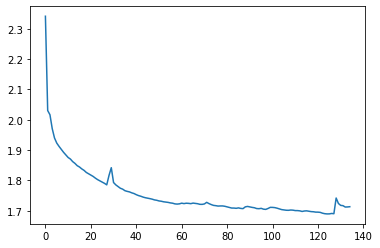

In [13]:
l = train(network, dataloader, batch_size = batch_size, epochs=135, optimizer=optimizer)